In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('SHOP.csv')
df1=df.reset_index()['Close']
df1.info

<bound method Series.info of 0       13.760000
1       12.979000
2       13.806000
3       14.439000
4       14.544000
          ...    
1107    57.709999
1108    59.259998
1109    58.189999
1110    57.189999
1111    57.939999
Name: Close, Length: 1112, dtype: float64>

In [2]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [3]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [4]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [5]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [6]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [7]:


model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [8]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 7s 233ms/step - loss: 0.1188 - val_loss: 0.0217
Epoch 2/100
11/11 [==============================] - 1s 132ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 3/100
11/11 [==============================] - 1s 135ms/step - loss: 0.0087 - val_loss: 0.0031
Epoch 4/100
11/11 [==============================] - 1s 133ms/step - loss: 0.0054 - val_loss: 0.0022
Epoch 5/100
11/11 [==============================] - 1s 131ms/step - loss: 0.0046 - val_loss: 6.2824e-04
Epoch 6/100
11/11 [==============================] - 1s 134ms/step - loss: 0.0038 - val_loss: 6.1618e-04
Epoch 7/100
11/11 [==============================] - 1s 133ms/step - loss: 0.0038 - val_loss: 8.3873e-04
Epoch 8/100
11/11 [==============================] - 2s 140ms/step - loss: 0.0036 - val_loss: 8.6077e-04
Epoch 9/100
11/11 [==============================] - 1s 136ms/step - loss: 0.0035 - val_loss: 7.2500e-04
Epoch 10/100
11/11 [==============================] - 1s 131ms/step - l

In [9]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 37ms/step


In [10]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [11]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 59.172581979431484
Testing RMSE: 34.01611120918636


In [22]:
val_data.size

112

In [13]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[12:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.2861174]
101
1 day input [0.1506974  0.15031297 0.15236319 0.16600995 0.17299351 0.16780389
 0.16069222 0.17619697 0.19900565 0.19035628 0.22008446 0.22649139
 0.23770352 0.21918747 0.23251389 0.23885674 0.26044811 0.25596326
 0.24724983 0.24584029 0.23590956 0.23488445 0.22629916 0.22886195
 0.23789572 0.25891044 0.20457968 0.19625067 0.18221948 0.18612771
 0.18837015 0.17792685 0.17619697 0.18042555 0.17376233 0.18068183
 0.19490522 0.19541776 0.18888269 0.1968273  0.19234244 0.18247576
 0.18452598 0.19746798 0.19580219 0.203042   0.20310608 0.19798055
 0.20989744 0.20490002 0.21021778 0.20502816 0.20560478 0.20073553
 0.21604809 0.21483075 0.22399266 0.22232687 0.22175025 0.20637361
 0.20739872 0.20739872 0.20374677 0.20707837 0.20983336 0.21406193
 0.2277087  0.23206541 0.23110436 0.22437709 0.23039959 0.22450523
 0.21451041 0.21393379 0.22175025 0.22726021 0.21976409 0.21656063
 0.2132931  0.28396153 0.31426631 0.32932258 0.3261832  0.3215702
 0.31984035 0.30978148 0.31138321 0

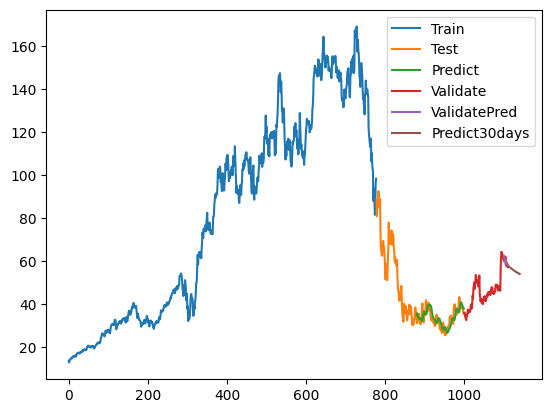

In [21]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()